In [2]:
library(data.table)
library(Rmisc)
library(ggplot2)
library(dplyr)
library(reshape2)
library(bit)
library(zoo)

## Data Preperation

### 1. Read raw data (i.e., reviews)

In [3]:
DIR = "../data/"
rws=fread(paste0(DIR,"rws.all.csv"))

### 2. Read facial attributes for both hosts and guests and merge those attributes with the review data

In [4]:
guest=fread(paste0(DIR,"guest.attribute.csv"))
colnames(guest)[c(8)]=c("g.ethnicity")
guest=guest[,c("guest_id","g.ethnicity")]
rws.gh=left_join(rws,guest, by="guest_id",type='left')

In [5]:
host=fread(paste0(DIR,"host.attribute.csv"))
colnames(host)[c(8)]=c("h.ethnicity")
host=host[,c("listing_id","host_id","h.ethnicity")]
rws.gh=left_join(rws.gh,host, by=c("listing_id","host_id"))

In [6]:
#-Remove those racially unidentified guests
rws.gh=rws.gh[rws.gh$g.ethnicity!="",]
rws.gh=rws.gh[rws.gh$h.ethnicity!="",]
rws.gh

listing_id,host_id,instant_bookable,id,date,guest_id,reviewer_name,gld_id,g.ethnicity,h.ethnicity
<int>,<int>,<chr>,<int>,<date>,<int>,<chr>,<chr>,<chr>,<chr>
2595,2845,t,17857,2009-11-21,50679,Jean,50679-2595-2009-11-21,ASIAN,WHITE
2595,2845,t,19760,2009-12-10,38960,Anita,38960-2595-2009-12-10,BLACK,WHITE
2595,2845,t,34320,2010-04-09,71130,Kai-Uwe,71130-2595-2010-04-09,WHITE,WHITE
2595,2845,t,46312,2010-05-25,117113,Alicia,117113-2595-2010-05-25,WHITE,WHITE
2595,2845,t,1293632,2012-05-17,1870771,Loïc,1870771-2595-2012-05-17,WHITE,WHITE
2595,2845,t,15515108,2014-07-10,10781357,Richard,10781357-2595-2014-07-10,WHITE,WHITE
2595,2845,t,20372242,2014-09-28,4212558,Carson,4212558-2595-2014-09-28,WHITE,WHITE
2595,2845,t,20937971,2014-10-07,13460520,Michael,13460520-2595-2014-10-07,WHITE,WHITE
2595,2845,t,21464102,2014-10-18,16584002,Kitty,16584002-2595-2014-10-18,WHITE,WHITE


### 3. Create booking- / staying-level reputation and endorsement signals

#### 3.1. Create columns for # of previous reviews and race of previous reviewers for each booking/staying

In [7]:
df=rws.gh

In [8]:
df=df %>% group_by(listing_id) %>% arrange(date) %>%
   mutate(cum.cnt=row_number()-1,
          rws.race=lag(g.ethnicity, n = 1, default = NA))

#### 3.2. Count the previous guest race for each booking

In [9]:
#-Create column and add counter
df$g.W.cnt=ifelse(df$rws.race=="WHITE", 1, 0)
df$g.B.cnt=ifelse(df$rws.race=="BLACK", 1, 0)
df$g.A.cnt=ifelse(df$rws.race=="ASIAN", 1, 0)

In [10]:
#-Code the first review's the most recent previous reviewer's race as 0
#-and then count all the previous reviewers' races cumulatively
df$rws.race[which(is.na(df$rws.race))]=0

df = df %>% group_by(listing_id) %>% arrange(date) %>% 
    mutate(g.W.cnt=cumsum(rws.race=="WHITE"),
           g.B.cnt=cumsum(rws.race=="BLACK"),
           g.A.cnt=cumsum(rws.race=="ASIAN"))

In [11]:
df=as.data.table(df)

df$prop.W=df$g.W.cnt/df$cum.cnt
df$prop.B=df$g.B.cnt/df$cum.cnt
df$prop.A=df$g.A.cnt/df$cum.cnt

df$prop.W2=NA
df$prop.W2=as.character(df$prop.W2)
df=df[prop.W<0.25, prop.W2 := "< 25%"]
df=df[prop.W>=0.25 & prop.W<0.5, prop.W2 := "25-50%"]
df=df[prop.W>=0.5 & prop.W<0.75, prop.W2 := "50-75%"]
df=df[prop.W>=0.75, prop.W2 := "75-100%"]
table(df$prop.W2)

df$prop.B2=NA
df$prop.B2=as.character(df$prop.B2)
df=df[prop.B<0.25, prop.B2 := "< 25%"]
df=df[prop.B>=0.25 & prop.B<0.5, prop.B2 := "25-50%"]
df=df[prop.B>=0.5 & prop.B<0.75, prop.B2 := "50-75%"]
df=df[prop.B>=0.75, prop.B2 := "75-100%"]
table(df$prop.B2)

df$prop.A2=NA
df$prop.A2=as.character(df$prop.A2)
df=df[prop.A<0.25, prop.A2 := "< 25%"]
df=df[prop.A>=0.25 & prop.A<0.5, prop.A2 := "25-50%"]
df=df[prop.A>=0.5 & prop.A<0.75, prop.A2 := "50-75%"]
df=df[prop.A>=0.75, prop.A2 := "75-100%"]
table(df$prop.A2)


 25-50%  50-75% 75-100%   < 25% 
  49876  179230   68093   17091 


 25-50%  50-75% 75-100%   < 25% 
  47416   11743    5126  250005 


 25-50%  50-75% 75-100%   < 25% 
 103603   17347    6343  186997 

In [12]:
df=as.data.table(df)

In [13]:
#-Extract only listings that allow instant booking
df=df[which(df$instant_bookable=="t"),]

# ----------------------------------------------------------------------------------------

## Pairing probability between racial groups conditional on the proportion of same-race reviews

- A variation of Fig. 3

### 1. Compute paring probabilities across different race combinations

#### 1.1. Extract only relevant columns and create counterfactuals

In [14]:
create_ctf_1 = function(df.x) {
    df.tmp.ctf=df.x
    df.tmp.ctf$pairing.status=0
    df.tmp.ctf$g.ethnicity=ifelse(df.tmp.ctf$g.ethnicity=="BLACK" |
                                  df.tmp.ctf$g.ethnicity=="ASIAN",
                                  "WHITE", "BLACK")
    return(df.tmp.ctf)
}

create_ctf_2 = function(df.x) {
    df.tmp.ctf=df.x
    df.tmp.ctf$pairing.status=0
    df.tmp.ctf$g.ethnicity=ifelse(df.tmp.ctf$g.ethnicity=="BLACK" |
                                  df.tmp.ctf$g.ethnicity=="WHITE",
                                  "ASIAN", "BLACK")
    return(df.tmp.ctf)
}

create_ctf = function(df.x) {
    return(rbind(create_ctf_1(df.x),create_ctf_2(df.x)))
}

In [15]:
df.tmp.obs=df

In [16]:
df.tmp.obs=df.tmp.obs[, c("h.ethnicity", "g.ethnicity",
                          "prop.W2", "prop.B2", "prop.A2"), with=FALSE]
df.tmp.obs$pairing.status=1

In [17]:
df.tmp.ctf=create_ctf(df.tmp.obs)

#### 1.2. Combine counterfactuals with observations and compute average pairing probabilities 

In [18]:
df.obs.ctf=rbind(df.tmp.obs,df.tmp.ctf)

In [19]:
df.obs.ctf$sre[df.obs.ctf$g.ethnicity=="WHITE"]=df.obs.ctf$prop.W2[df.obs.ctf$g.ethnicity=="WHITE"]
df.obs.ctf$sre[df.obs.ctf$g.ethnicity=="ASIAN"]=df.obs.ctf$prop.A2[df.obs.ctf$g.ethnicity=="ASIAN"]
df.obs.ctf$sre[df.obs.ctf$g.ethnicity=="BLACK"]=df.obs.ctf$prop.B2[df.obs.ctf$g.ethnicity=="BLACK"]

In [20]:
df.obs.ctf=df.obs.ctf[complete.cases(df.obs.ctf), ]

In [21]:
summary.pairing.prob.obs=summarySE(df.obs.ctf, measurevar="pairing.status",
                                   groupvars=c("h.ethnicity",
                                               "g.ethnicity",
                                               "sre"))

### 2. Compute the pairing probabilities compared to the random baseline and plot the results

#### 2.1. Create n random baselines (for standard errors) and compute the difference with the observations

- Fully computed normed probabilities are available (check ***2.2*** without running code in ***2.1***)

In [22]:
df.tmp.rnd=df.tmp.obs

In [23]:
#-Permutate g.ethnicity for n times to create a random baseline
#-to compare the difference between obeservations and random chances
#-as well as to create standard errors... .

start_time=Sys.time()

shuffle_time=1000
l_rand=list()
l_diff=list()
for(x in 1:shuffle_time){
    df.tmp=df.tmp.rnd
    df.tmp$g.ethnicity=df.tmp.rnd[sample(nrow(df.tmp.rnd)),]$g.ethnicity
    
    df.tmp.ctf=create_ctf(df.tmp)
    df.tmp.rnd.ctf=rbind(df.tmp,df.tmp.ctf)

    df.tmp.rnd.ctf$sre[df.tmp.rnd.ctf$g.ethnicity=="WHITE"]=df.tmp.rnd.ctf$prop.W2[df.tmp.rnd.ctf$g.ethnicity=="WHITE"]
    df.tmp.rnd.ctf$sre[df.tmp.rnd.ctf$g.ethnicity=="ASIAN"]=df.tmp.rnd.ctf$prop.A2[df.tmp.rnd.ctf$g.ethnicity=="ASIAN"]
    df.tmp.rnd.ctf$sre[df.tmp.rnd.ctf$g.ethnicity=="BLACK"]=df.tmp.rnd.ctf$prop.B2[df.tmp.rnd.ctf$g.ethnicity=="BLACK"]
    
    df.tmp.rnd.ctf=df.tmp.rnd.ctf[complete.cases(df.tmp.rnd.ctf), ]
    
    df.tmp.pairing.prob.obs=summarySE(df.tmp.rnd.ctf, measurevar="pairing.status",
                                      groupvars=c("h.ethnicity", "g.ethnicity", "sre"))
    l_rand[[paste("g.rnd.ethnicity", x, sep=".")]]=df.tmp.pairing.prob.obs
    df.tmp.diff=df.tmp.pairing.prob.obs[,1:3]
    df.tmp.diff$prob.diff=summary.pairing.prob.obs$pairing.status - df.tmp.pairing.prob.obs$pairing.status
    l_diff[[paste("obs.rnd.diff", x, sep=".")]]=df.tmp.diff
}

end_time=Sys.time()
end_time - start_time

Time difference of 8.731893 mins

In [24]:
df.pairing.prob.diff=do.call(rbind.data.frame, l_diff)

#### 2.2. Compute the mean (and CI) of the probability difference

In [ ]:
#-Read
summary.pairing.prob.obs=readRDS("../data/supp_fig_s3_summary.pairing.prob.obs.RDS")
df.pairing.prob.diff=readRDS("../data/supp_fig_s3_pairing.prob.diff.RDS")

In [26]:
summary.pairing.prob.diff=summarySE(df.pairing.prob.diff, measurevar="prob.diff",
                                    groupvars=c("h.ethnicity", "g.ethnicity", "sre"))

In [27]:
summary.pairing.prob.diff$ci=summary.pairing.prob.diff$sd*1.96

#### 2.3. Plot the results

In [28]:
re_from="\\b([[:alpha:]])([[:alpha:]]+)"
summary.pairing.prob.diff$h.ethnicity=gsub(re_from, "\\U\\1\\L\\2", summary.pairing.prob.diff$h.ethnicity, perl=TRUE)

In [29]:
summary.pairing.prob.diff$h.ethnicity=factor(summary.pairing.prob.diff$h.ethnicity,
                                             levels=c("White","Asian","Black"),
                                             ordered=TRUE)

In [30]:
summary.pairing.prob.diff$g.ethnicity=factor(summary.pairing.prob.diff$g.ethnicity,
                                             levels=c("WHITE","ASIAN","BLACK"),
                                             ordered=TRUE)

In [32]:
summary.pairing.prob.diff$sre=factor(summary.pairing.prob.diff$sre,
                                     levels=c("< 25%","25-50%","50-75%","75-100%"),
                                     ordered=TRUE)

In [33]:
l_guest.race.label=c(
    "BLACK"="Black Guest",
    "WHITE"="White Guest",
    "ASIAN"="Asian Guest")
cc=c("#2c2d4a","#be5d05","#f1aa00")

dodge=position_dodge(width=0.5)
pdf("../output/supp_fig_s3.pdf", width=7.5, height=8.5)
g = ggplot(summary.pairing.prob.diff, aes(x=sre, y=prob.diff)) + 
  geom_line(position=dodge, size=1, aes(color=h.ethnicity, group=h.ethnicity)) +
  xlab("Proportion of Same-Race Endorsements Among all Reviews\n(Not Just Front-page Reviews)") + 
  ylab("Pairing Probability Compared to Random") +
  geom_point(position=dodge, aes(color=h.ethnicity, group=h.ethnicity), size=2.5) +
  geom_errorbar(aes(ymin=prob.diff-ci, ymax=prob.diff+ci, color=h.ethnicity),
                size=0.9, width=0.15, position=dodge) +
  scale_color_manual(values=cc) +
  facet_grid(g.ethnicity~., margins=FALSE, switch="y", scales="free_y",
             labeller=as_labeller(l_guest.race.label)) + labs(color="Host Race") +
             theme_classic() + theme(panel.border=element_rect(fill=NA, size=0.3)) +
  coord_cartesian(ylim=c(-0.2,0.25)) +
  geom_hline(yintercept=0, linetype="dashed", color="#D55E00") +
  theme(legend.position="top",
        legend.justification='left',
        panel.grid.major=element_blank(),
        text=element_text(size=15))
plot(g)
dev.off()

pdf 
  2

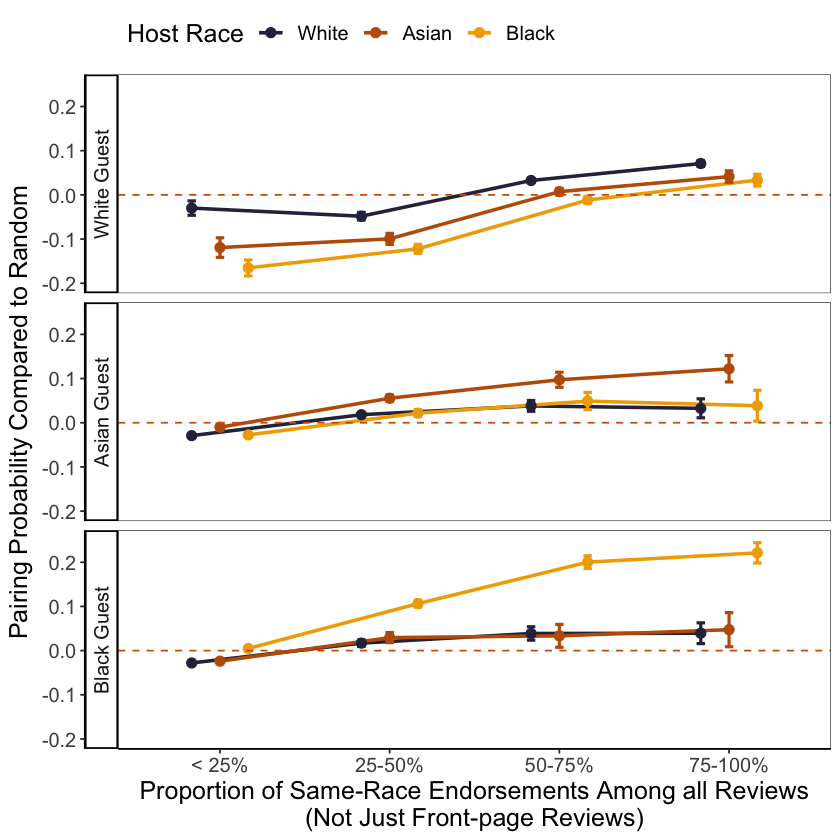

In [34]:
g